In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Poisson
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

% matplotlib inline

In [2]:
# Create a Dataframe and drop extra column
df = pd.read_csv('./data/features_seattle_911_no_dup_hoods.csv', low_memory=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
df.head()

Address                     Type             Datetime  \
0           6900 37th Av S           Medic Response  2011-11-09 23:33:00   
1  N 50th St / Stone Way N             Aid Response  2011-11-09 23:32:00   
2  E John St / E Olive Way             Aid Response  2011-11-09 23:32:00   
3            611 12th Av S             Aid Response  2011-11-09 23:29:00   
4          4545 42nd Av Sw  Automatic Medical Alarm  2011-11-09 23:25:00   

    Latitude   Longitude           Report Location Incident Number  \
0  47.540683 -122.286131  (47.540683, -122.286131)      F110104166   
1  47.665034 -122.340207  (47.665034, -122.340207)      F110104164   
2  47.619575 -122.324257  (47.619575, -122.324257)      F110104165   
3  47.597406 -122.317228  (47.597406, -122.317228)      F110104162   
4  47.562472 -122.385455  (47.562472, -122.385455)      F110104161   

                  dt_crop        date      time  ...   Wednesday day_num  \
0  11/09/2011 11:33:00 PM  2011-11-09  23:33:00  ...           1     498   
1  11/09/2011 11:32:00 PM  2011-11-09  23:32:00  ...           1     498   
2  11/09/2011 11:32:00 PM  2011-11-09  23:32:00  ...           1     498   
3  11/09/2011 11:29:00 PM  2011-11-09  23:29:00  ...           1     498   
4  11/09/2011 11:25:00 PM  2011-11-09  23:25:00  ...           1     498   

             neighborhood  zone1  zone2  zone3  zone4 zone5  zone6  zone7  
0              Holly Park      0      0      0      0     0      0      1  
1             Wallingford      1      0      0      0     0      0      0  
2                Broadway      0      0      0      1     0      0      0  
3  International District      0      0      0      0     1      0      0  
4                 Genesee      0      0      0      0     0      1      0  

[5 rows x 34 columns]

In [25]:
df2 = df.drop(labels=(['Address', 'Type', 'Report Location', 'Incident Number',
                 'dt_crop', 'neighborhood', 'date2', 'time2', 'weekday',
                 'Latitude', 'Longitude', 'time', 'Datetime', 'date']), axis=1)
df2.head()

mariners_home  seahawks_home  sounders_home  trav_holiday  dang_holiday  \
0              0              0              0             0             0   
1              0              0              0             0             0   
2              0              0              0             0             0   
3              0              0              0             0             0   
4              0              0              0             0             0   

   night  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  day_num  \
0      1       0         0       0         0        0          1      498   
1      1       0         0       0         0        0          1      498   
2      1       0         0       0         0        0          1      498   
3      1       0         0       0         0        0          1      498   
4      1       0         0       0         0        0          1      498   

   zone1  zone2  zone3  zone4  zone5  zone6  zone7  
0      0      0      0      0      0      0      1  
1      1      0      0      0      0      0      0  
2      0      0      0      1      0      0      0  
3      0      0      0      0      1      0      0  
4      0      0      0      0      0      1      0

In [26]:
df2.to_csv('./data/model_data.csv')

In [2]:
# R used to fix dataframe for Poisson model
df3 = pd.read_csv('./data/model_data_counted.csv', low_memory=False)
df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [12]:
df3.head()

mariners_home  seahawks_home  sounders_home  trav_holiday  dang_holiday  \
0              0              0              0             0             0   
1              0              0              0             0             0   
2              0              0              0             0             0   
3              0              0              0             0             0   
4              0              0              0             0             0   

   night  Monday  Saturday  Sunday  Thursday  ...   Wednesday  day_num  zone1  \
0      0       0         0       0         0  ...           0        3      0   
1      0       0         0       0         0  ...           0        3      0   
2      0       0         0       0         0  ...           0        3      0   
3      0       0         0       0         0  ...           0        3      0   
4      0       0         0       0         0  ...           0        3      0   

   zone2  zone3  zone4  zone5  zone6  zone7  freq  
0      0      0      0      0      0      0     3  
1      0      0      0      0      0      1    27  
2      0      0      0      0      1      0    23  
3      0      0      0      1      0      0    29  
4      0      0      1      0      0      0    40  

[5 rows x 21 columns]

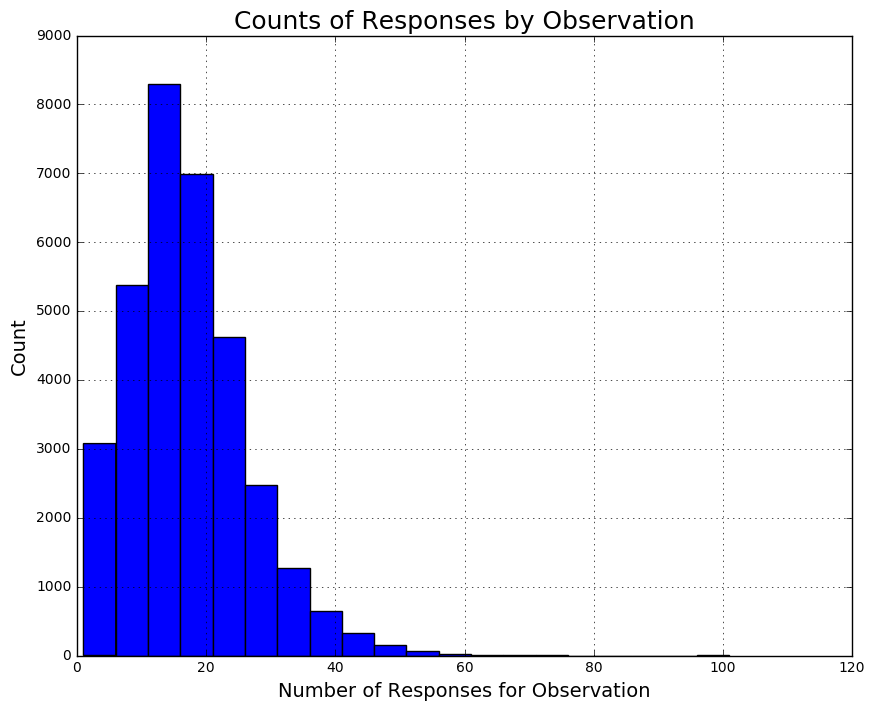

In [28]:
plt.figure(figsize=(10,8))
df3.freq.hist(bins=20)
plt.title('Counts of Responses by Observation', fontsize=18)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Number of Responses for Observation', fontsize=14)

In [29]:
df3.day_num.max()

2304

In [30]:
# Create test and trainging sets
df_train = df3[(df3.day_num < 1300) | (df3.day_num > 1600)]
df_test = df3[(df3.day_num >= 1300) & (df3.day_num <= 1600)]

# Create X and y
y_train = df_train.pop('freq')
X_train = df_train
y_test = df_test.pop('freq')
X_test = df_test

# Scale X
# scaler = StandardScaler(with_mean=False)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [31]:
model = Poisson(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 3.211140
         Iterations 34


In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                   freq   No. Observations:                28897
Model:                        Poisson   Df Residuals:                    28877
Method:                           MLE   Df Model:                           19
Date:                Sun, 13 Nov 2016   Pseudo R-squ.:                  0.3369
Time:                        13:14:22   Log-Likelihood:                -92792.
converged:                       True   LL-Null:                   -1.3993e+05
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
mariners_home     0.0280      0.003      8.455      0.000         0.022     0.034
seahawks_home    -0.0241      0.010     -2.330      0.020        -0.044    -0.004
sounders_home     0.0360      0.007      5.110      0.000         0.022     0.050
trav_holiday     -0.0722      0.011     -6.353      0.000        -0.094    -0.050
dang_holiday      0.1545      0.017      8.876      0.000         0.120     0.189
night             0.2873      0.003     98.090      0.000         0.282     0.293
Monday           -0.0420      0.005     -7.756      0.000        -0.053    -0.031
Saturday          0.0015      0.005      0.268      0.789        -0.009     0.012
Sunday           -0.0196      0.006     -3.503      0.000        -0.031    -0.009
Thursday         -0.0312      0.005     -5.789      0.000        -0.042    -0.021
Tuesday          -0.0360      0.005     -6.690      0.000        -0.047    -0.025
Wednesday        -0.0315      0.005     -5.867      0.000        -0.042    -0.021
day_num           0.0002   2.06e-06     75.398      0.000         0.000     0.000
zone1             2.6634      0.006    454.484      0.000         2.652     2.675
zone2             2.4395      0.006    397.840      0.000         2.428     2.452
zone3             2.0390      0.007    301.966      0.000         2.026     2.052
zone4             2.6088      0.006    440.532      0.000         2.597     2.620
zone5             3.0048      0.006    543.311      0.000         2.994     3.016
zone6             2.2308      0.006    346.895      0.000         2.218     2.243
zone7             2.3857      0.006    384.355      0.000         2.374     2.398
=================================================================================
"""

In [33]:
y_hat = model.predict(X_test) 

In [34]:
mean_squared_error(y_test, y_hat)

25.90146793579374

In [35]:
print y_hat - y_test

881      -0.689617
882       0.399557
883      -3.281126
884       9.637025
885      -1.589345
886      -0.953809
887       7.570367
888       1.324871
889       1.411965
890       1.745779
891       8.655134
892       3.420898
893       3.061480
894       3.589491
895       1.339375
896       0.424386
897      -5.227286
898       0.673262
899      -0.568847
900      -0.923215
901      -0.391363
902      -0.646106
903      -4.563179
904      -3.200322
905      -5.308590
906       0.441418
907       0.092108
908       6.627803
909       6.368429
910       5.449270
           ...    
33276     2.212557
33277     2.454420
33278    -2.320127
33279    10.014320
33280    -4.416413
33281     1.274642
33282     2.361530
33283    -0.222390
33284   -10.682654
33285    -1.455835
33286    -4.125522
33287     6.145298
33288     2.657675
33289     0.385224
33290     2.499856
33291    -0.206852
33292    -0.513802
33293    -2.311223
33294    -1.811945
33295     0.356351
33296     3.777056
33297     7.

In [45]:
'''
Questions:
1. Scaling not required?
2. Dep Variable freq vs count?
3. Refactor day in 12 hr rather than 24 hr?
'''

In [37]:
model_boosting = GradientBoostingRegressor(subsample=0.5, n_estimators=10000, learning_rate=0.001)

In [38]:
model_boosting.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.001,
             loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=None, subsample=0.5, verbose=0,
             warm_start=False)

In [39]:
y_hat_boost = model_boosting.predict(X_test)

In [40]:
mean_squared_error(y_test, y_hat_boost)

32.19213946662304

In [41]:
model_forest = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features='sqrt')

In [42]:
model_forest.fit(X_train, y_train, )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [43]:
y_hat_for = model_forest.predict(X_test)

In [44]:
mean_squared_error(y_test, y_hat_for)

34.120405660432624